# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

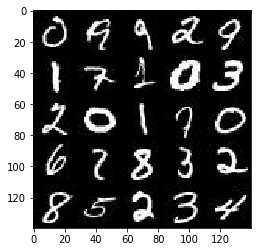

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

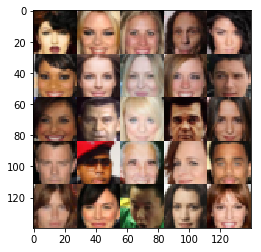

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    realInputImages = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='realInputImages')
    zData = tf.placeholder(tf.float32, (None, z_dim), name='zData')
    learningRate = tf.placeholder(tf.float32)

    return realInputImages, zData, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        discOut = tf.sigmoid(logits)
        
    return discOut, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    
    with tf.variable_scope('generator', reuse= not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x"out_channel_dim" now
                
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    
    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, l_rate:learning_rate})
                
                if steps % 10 == 0:
                    # After 10 steps, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    # After 100 steps, print sample images
                    show_generator_output(sess, 50, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 36.2203
Epoch 1/2... Discriminator Loss: 36.9344... Generator Loss: 40.9370
Epoch 1/2... Discriminator Loss: 0.9683... Generator Loss: 1.0706
Epoch 1/2... Discriminator Loss: 4.1483... Generator Loss: 0.1472
Epoch 1/2... Discriminator Loss: 2.0425... Generator Loss: 0.2770
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.4054
Epoch 1/2... Discriminator Loss: 3.2035... Generator Loss: 0.1051
Epoch 1/2... Discriminator Loss: 2.4577... Generator Loss: 0.1707
Epoch 1/2... Discriminator Loss: 2.4731... Generator Loss: 0.1595
Epoch 1/2... Discriminator Loss: 1.9131... Generator Loss: 0.2633


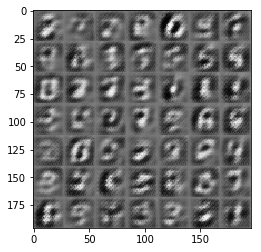

Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 1.9349... Generator Loss: 0.2475
Epoch 1/2... Discriminator Loss: 1.8471... Generator Loss: 0.3024
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.5552
Epoch 1/2... Discriminator Loss: 2.5006... Generator Loss: 2.8258
Epoch 1/2... Discriminator Loss: 1.5192... Generator Loss: 2.0224
Epoch 1/2... Discriminator Loss: 1.8899... Generator Loss: 2.6437
Epoch 1/2... Discriminator Loss: 1.7662... Generator Loss: 1.9855
Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 1.4463
Epoch 1/2... Discriminator Loss: 2.1849... Generator Loss: 0.1624


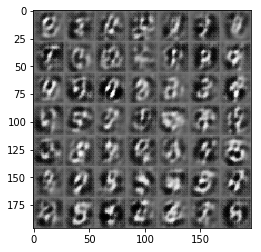

Epoch 1/2... Discriminator Loss: 2.2685... Generator Loss: 0.1461
Epoch 1/2... Discriminator Loss: 1.7910... Generator Loss: 0.2629
Epoch 1/2... Discriminator Loss: 0.4310... Generator Loss: 1.6587
Epoch 1/2... Discriminator Loss: 1.6342... Generator Loss: 0.4615
Epoch 1/2... Discriminator Loss: 1.6471... Generator Loss: 0.3264
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 0.7633
Epoch 1/2... Discriminator Loss: 2.2163... Generator Loss: 2.7706
Epoch 1/2... Discriminator Loss: 0.4111... Generator Loss: 1.5270
Epoch 1/2... Discriminator Loss: 1.9139... Generator Loss: 3.3696
Epoch 1/2... Discriminator Loss: 1.5180... Generator Loss: 0.8910


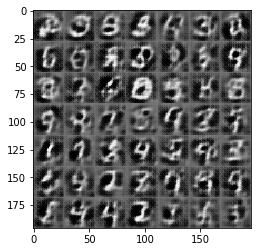

Epoch 1/2... Discriminator Loss: 2.2059... Generator Loss: 0.1641
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 0.5942
Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 0.5814
Epoch 1/2... Discriminator Loss: 0.6649... Generator Loss: 1.7269
Epoch 1/2... Discriminator Loss: 1.4431... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 0.9645
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 1.1223
Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 2.7024... Generator Loss: 0.1077
Epoch 1/2... Discriminator Loss: 1.1534... Generator Loss: 0.5172


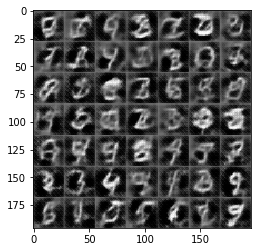

Epoch 1/2... Discriminator Loss: 1.8722... Generator Loss: 0.2180
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.4642
Epoch 1/2... Discriminator Loss: 1.5926... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 1.5569... Generator Loss: 2.9890
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 1.5466
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 1.5775
Epoch 1/2... Discriminator Loss: 1.8962... Generator Loss: 0.2568
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 1.0872
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 1.6319
Epoch 1/2... Discriminator Loss: 1.6236... Generator Loss: 3.4801


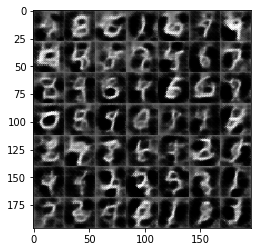

Epoch 1/2... Discriminator Loss: 1.6433... Generator Loss: 2.0737
Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 1.6390
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.3502
Epoch 1/2... Discriminator Loss: 2.6732... Generator Loss: 0.1040
Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 0.3705
Epoch 1/2... Discriminator Loss: 1.7026... Generator Loss: 0.3381
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 1.6630
Epoch 1/2... Discriminator Loss: 1.4423... Generator Loss: 2.1032
Epoch 1/2... Discriminator Loss: 1.7788... Generator Loss: 0.3447
Epoch 1/2... Discriminator Loss: 1.5433... Generator Loss: 0.3376


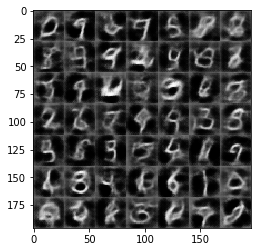

Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 1.7148... Generator Loss: 0.3203
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 2.4849... Generator Loss: 2.0214
Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 1.3781
Epoch 2/2... Discriminator Loss: 1.1404... Generator Loss: 1.3729
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 1.8788
Epoch 2/2... Discriminator Loss: 1.4686... Generator Loss: 1.5067
Epoch 2/2... Discriminator Loss: 1.3437... Generator Loss: 0.9590
Epoch 2/2... Discriminator Loss: 1.7980... Generator Loss: 0.2641


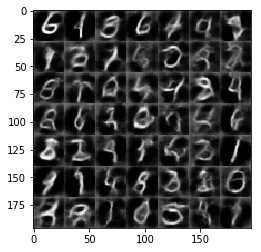

Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 0.4566
Epoch 2/2... Discriminator Loss: 1.8007... Generator Loss: 0.4649
Epoch 2/2... Discriminator Loss: 1.7307... Generator Loss: 0.2653
Epoch 2/2... Discriminator Loss: 1.6185... Generator Loss: 0.3319
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.3687
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 1.4969
Epoch 2/2... Discriminator Loss: 1.4573... Generator Loss: 1.7265
Epoch 2/2... Discriminator Loss: 1.4983... Generator Loss: 1.5259
Epoch 2/2... Discriminator Loss: 1.4038... Generator Loss: 1.5884
Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 1.7002


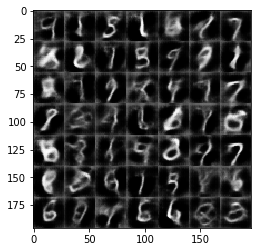

Epoch 2/2... Discriminator Loss: 1.0923... Generator Loss: 0.9501
Epoch 2/2... Discriminator Loss: 1.8054... Generator Loss: 1.7993
Epoch 2/2... Discriminator Loss: 1.2380... Generator Loss: 1.0981
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 1.3700
Epoch 2/2... Discriminator Loss: 1.4564... Generator Loss: 1.9327
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 1.4902
Epoch 2/2... Discriminator Loss: 1.3437... Generator Loss: 1.3915
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 1.0557
Epoch 2/2... Discriminator Loss: 1.6728... Generator Loss: 1.2518
Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 1.3009


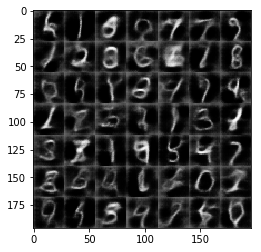

Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 1.4040
Epoch 2/2... Discriminator Loss: 1.4728... Generator Loss: 1.4130
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 1.2427
Epoch 2/2... Discriminator Loss: 1.5849... Generator Loss: 2.3381
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 1.3673
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 1.2986
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.6497
Epoch 2/2... Discriminator Loss: 1.7353... Generator Loss: 0.2638
Epoch 2/2... Discriminator Loss: 1.9363... Generator Loss: 0.2094


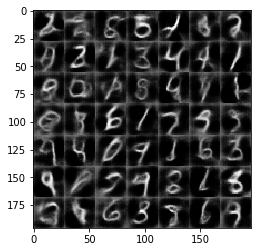

Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.7824
Epoch 2/2... Discriminator Loss: 1.5922... Generator Loss: 2.1456
Epoch 2/2... Discriminator Loss: 1.2529... Generator Loss: 1.2305
Epoch 2/2... Discriminator Loss: 1.5148... Generator Loss: 1.4688
Epoch 2/2... Discriminator Loss: 1.0362... Generator Loss: 1.2641
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 1.4522
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.8223
Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 0.9076
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 1.0328
Epoch 2/2... Discriminator Loss: 3.3185... Generator Loss: 3.3220


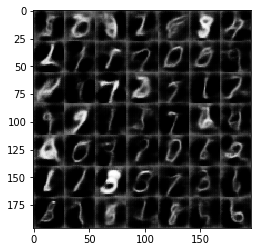

Epoch 2/2... Discriminator Loss: 1.5282... Generator Loss: 1.3459
Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 1.2733
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 0.9903
Epoch 2/2... Discriminator Loss: 1.4032... Generator Loss: 1.4006
Epoch 2/2... Discriminator Loss: 1.1699... Generator Loss: 1.3740
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 1.2816
Epoch 2/2... Discriminator Loss: 1.5959... Generator Loss: 0.9984
Epoch 2/2... Discriminator Loss: 2.0743... Generator Loss: 2.3549
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.5270
Epoch 2/2... Discriminator Loss: 1.8802... Generator Loss: 0.2099


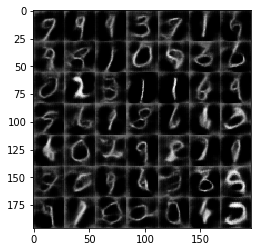

In [12]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 14.6450... Generator Loss: 0.0001
Epoch 1/1... Discriminator Loss: 2.5688... Generator Loss: 5.3007
Epoch 1/1... Discriminator Loss: 2.3874... Generator Loss: 2.1822
Epoch 1/1... Discriminator Loss: 2.7336... Generator Loss: 3.0771
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 2.0589
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.6848
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 3.4230
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 1.5339
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 3.7462
Epoch 1/1... Discriminator Loss: 0.0954... Generator Loss: 2.8798


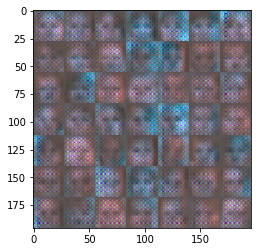

Epoch 1/1... Discriminator Loss: 0.0674... Generator Loss: 3.0489
Epoch 1/1... Discriminator Loss: 0.0663... Generator Loss: 3.7382
Epoch 1/1... Discriminator Loss: 14.2966... Generator Loss: 10.4238
Epoch 1/1... Discriminator Loss: 2.1213... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 1.8719... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 2.6916... Generator Loss: 3.3958
Epoch 1/1... Discriminator Loss: 1.7314... Generator Loss: 2.4265
Epoch 1/1... Discriminator Loss: 1.6034... Generator Loss: 1.5018
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 1.6323


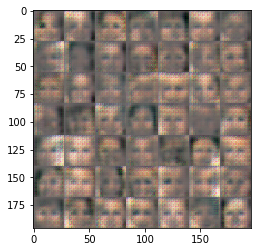

Epoch 1/1... Discriminator Loss: 2.1148... Generator Loss: 2.2783
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 2.0102
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 2.5061
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 3.9776
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.4499
Epoch 1/1... Discriminator Loss: 1.8215... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.9618... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 2.1352... Generator Loss: 0.1886
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.1919


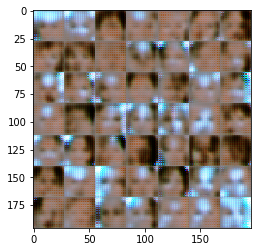

Epoch 1/1... Discriminator Loss: 2.1547... Generator Loss: 0.1869
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 1.6756
Epoch 1/1... Discriminator Loss: 1.7908... Generator Loss: 1.9919
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.9699... Generator Loss: 0.2965


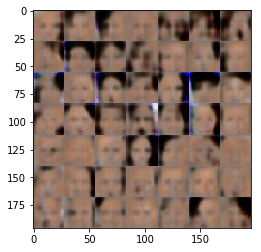

Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 1.2958
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 1.3355
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 1.2004
Epoch 1/1... Discriminator Loss: 1.8127... Generator Loss: 0.3442


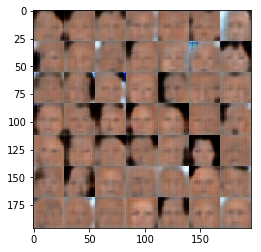

Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7756


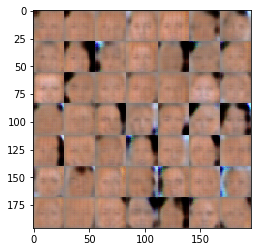

Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 1.1977
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 1.2164
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.8521... Generator Loss: 0.3158
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7925


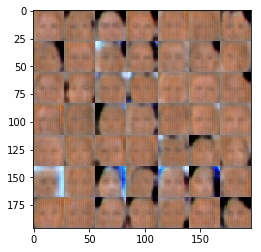

Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 1.3243
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.6269


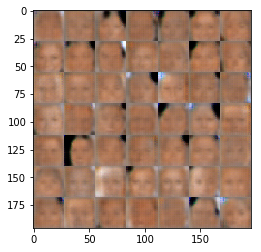

Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.3275
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.4138


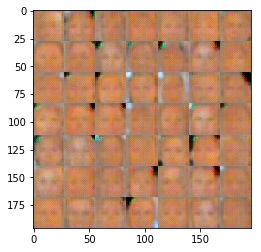

Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 2.0582
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.7316


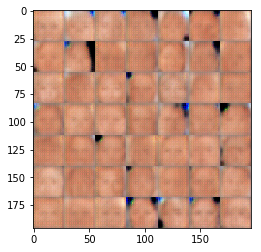

Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 1.6641
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.6549... Generator Loss: 0.3216
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.5946... Generator Loss: 0.3377
Epoch 1/1... Discriminator Loss: 1.8186... Generator Loss: 1.3947
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.9439


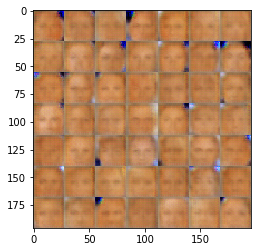

Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.6528


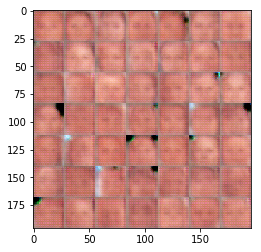

Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 1.2128
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.4371
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.5769... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.8224


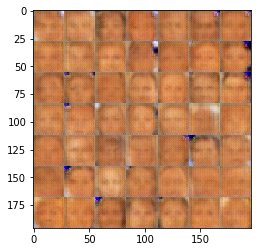

Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 1.0444


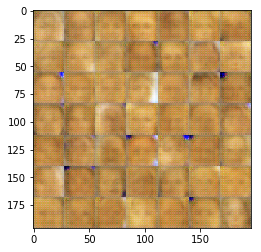

Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.3950
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.8022... Generator Loss: 1.2024
Epoch 1/1... Discriminator Loss: 2.8223... Generator Loss: 2.0781
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7193


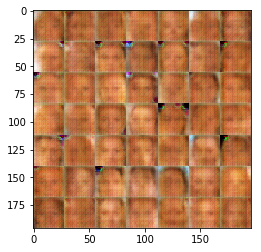

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.3929
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 1.5854
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 2.5203... Generator Loss: 2.3041
Epoch 1/1... Discriminator Loss: 2.6134... Generator Loss: 0.1882


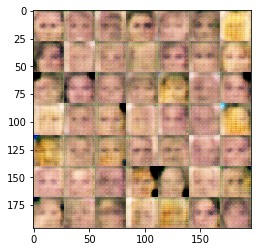

Epoch 1/1... Discriminator Loss: 1.6878... Generator Loss: 1.6506
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.6725... Generator Loss: 1.3983
Epoch 1/1... Discriminator Loss: 1.5785... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.5543


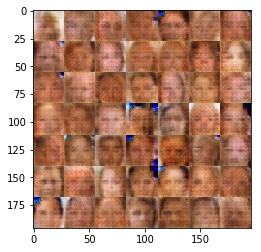

Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.3923


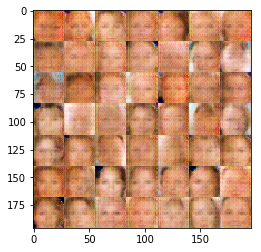

Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.3670


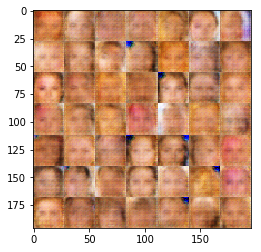

Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.3472
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5847


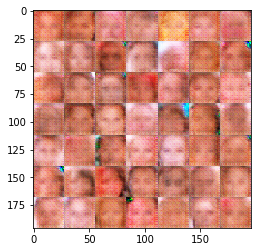

Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 1.2300


In [13]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.